In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
import mplleaflet

In [2]:
data = gpd.read_file("ranked-CD-EMP-flag.shp")

In [3]:
len(set(data['name']))

2064

In [4]:
data.columns

Index([u'BoroCT2010', u'BoroCT20_1',   u'BoroCode',   u'BoroName',
       u'BoroName_1',         u'CD', u'CDEligibil',     u'CT2010',
          u'CTLabel',        u'EMP',     u'Field1',    u'NTACode',
          u'NTAName',   u'OBJECTID',       u'PUMA', u'Shape_Ar_1',
       u'Shape_Area', u'Shape_Leng',          u'X', u'flag_agevu',
       u'flag_commu', u'flag_noins', u'flag_popde',   u'flag_pov',
             u'fpop',   u'geometry',      u'hhold', u'hhold_inco',
             u'mpop',       u'name',      u'noins', u'pct_age_vu',
       u'pct_f_vuln', u'pct_m_vuln',  u'pct_noins',    u'pct_pov',
       u'popdensity',        u'pov', u'rank_agevu', u'rank_commu',
       u'rank_incom', u'rank_noins', u'rank_popde',   u'rank_pov',
         u'rank_sum',   u'tempboro',   u'totalpop', u'transporta',
       u'trunctfips'],
      dtype='object')

In [5]:
data[data['BoroCode']=='4'].rank_sum

465     264.147287
466     345.251938
467     353.536822
468     352.470930
469     271.317830
470     343.217054
471     230.668605
472     292.490310
473     345.251938
474     266.279070
475     353.924419
476     311.579457
477     235.368217
478     259.205426
479       5.232558
480     328.536822
481     353.585271
482     327.325581
483     262.936046
484     440.988372
485     308.042636
486     374.903101
487     211.967054
488     264.147287
489     282.412791
490     301.308139
491     359.593023
492     299.515504
493     297.965116
494     335.998062
           ...    
1999    274.273256
2000    200.775194
2001    402.083333
2008    116.279070
2009    223.401163
2013    241.472868
2018    209.496124
2019    275.872093
2020    287.693799
2023    254.602713
2024    227.616279
2025    373.352713
2027    358.575581
2028    450.726744
2029    203.972868
2030    113.759690
2031    304.602713
2032    215.552326
2041    330.329457
2042    314.534884
2043    341.569767
2044    350.

In [6]:
psGeom = ps.open('ranked-CD-EMP-flag.shp', 'r')

In [7]:
W = ps.buildContiguity(psGeom, criterion='queen', ids=data['BoroCT2010'].values.tolist())

Island ids:  [u'3103400', u'4107201', u'2051600', u'2000100']


In [8]:
W['1015400']

{u'1014402': 1.0,
 u'1014602': 1.0,
 u'1014802': 1.0,
 u'1015200': 1.0,
 u'1015601': 1.0,
 u'1015801': 1.0}

In [9]:
W.transform = 'R'

In [10]:
W['1015400']

{u'1014402': 0.16666666666666666,
 u'1014602': 0.16666666666666666,
 u'1014802': 0.16666666666666666,
 u'1015200': 0.16666666666666666,
 u'1015601': 0.16666666666666666,
 u'1015801': 0.16666666666666666}

In [11]:
Y = data['rank_sum'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

In [12]:
sl = ps.lag_spatial(W, Y)
data['w_percent'] = sl

In [13]:
mi = ps.Moran(Y, W)
mi.I
mi.p_sim

0.001

In [14]:
mi.I

0.6574229850648613

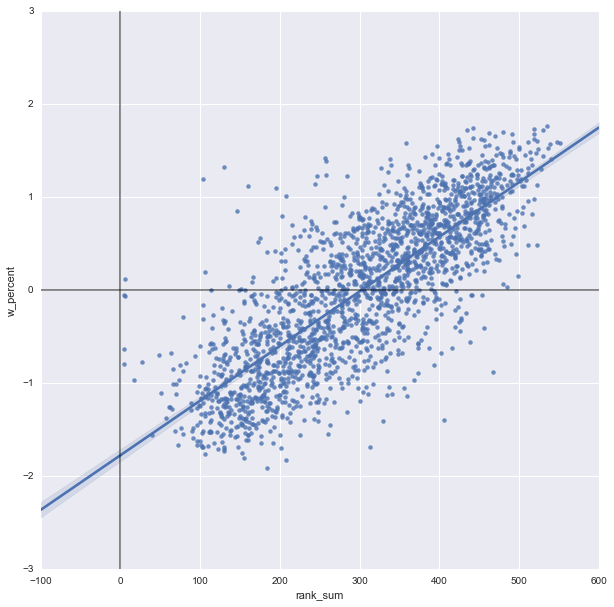

In [15]:
# It's time to look at the Moran Scatter Plot to inspet the results

f, ax = plt.subplots(1, figsize=(10,10))
sns.regplot(x='rank_sum', y='w_percent', data=data)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

AttributeError: 'Text' object has no attribute 'font'

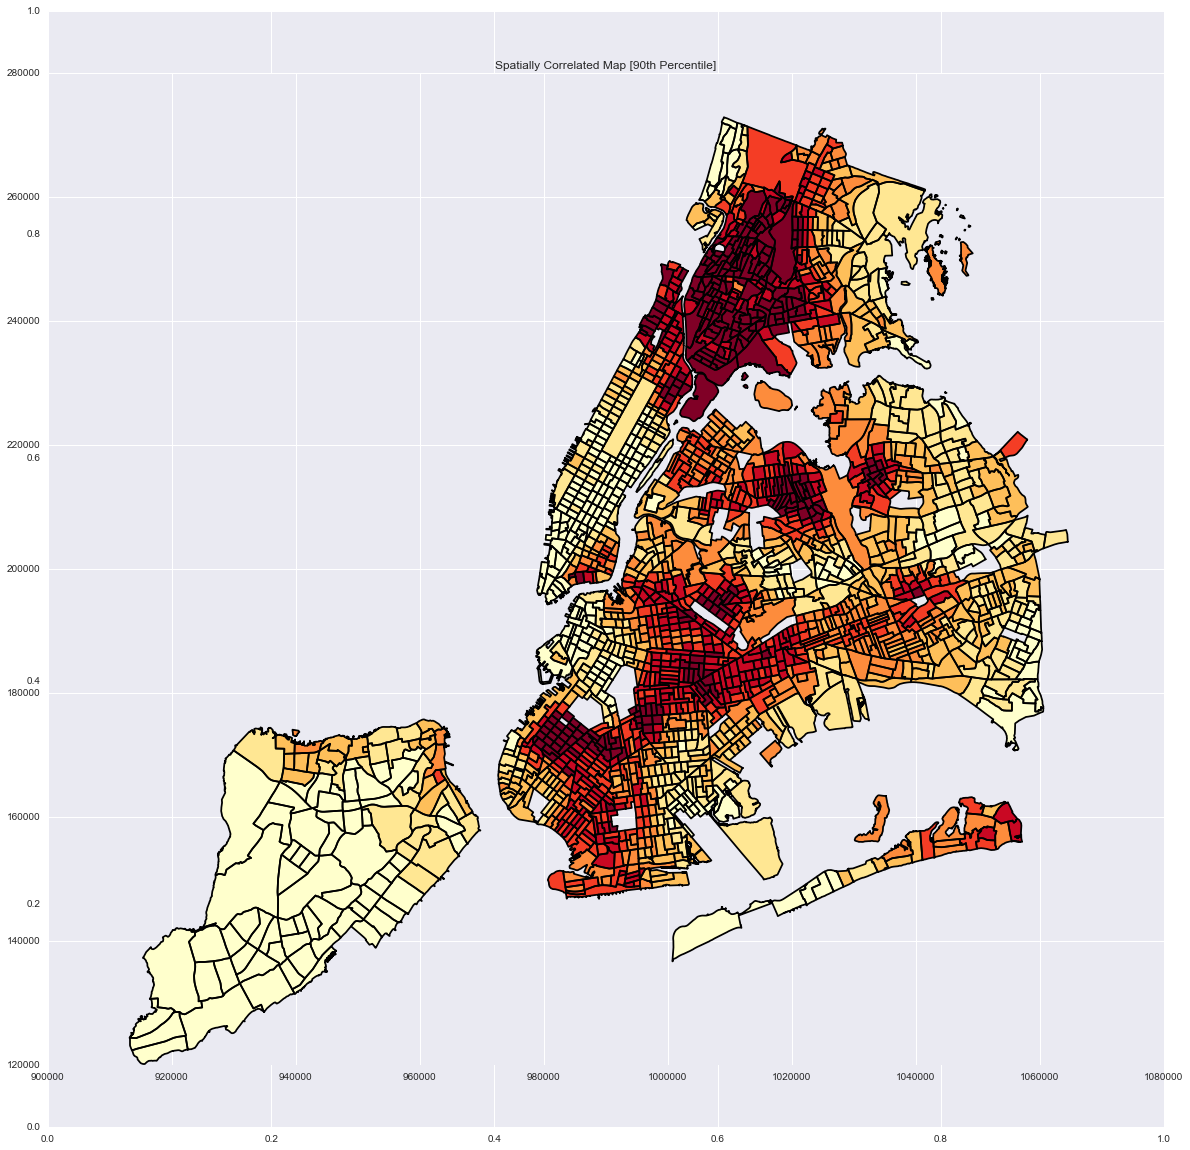

In [20]:
#### THE BELOW CODE SHOULD WORK FOR MOST INSTALLATION
f, ax = plt.subplots(1, figsize=(20,20))
data.plot(column='w_percent', scheme='QUANTILES',k=7, alpha=1, colormap='YlOrRd')#,label='data')

plt.title("Spatially Correlated Map [90th Percentile]")
plt.xlabel('Latitude')
plt.ylabel("Longitude")
#mplleaflet.display(fig=f, crs=data.crs)
#plt.legend()
#### BUT IF NOT, PLEASE USE THE BELOW INSTEAD (and comment the previous blob)
# data.plot(column='w_percent', scheme='QUANTILES', k=7, alpha=1.0, colormap='YlOrRd', figsize=(10,10))
# mplleaflet.display(crs=data.crs)

In [ ]:
data['Bo']

In [ ]:
data.plot(column='w_percent', scheme='QUANTILES', k=7, alpha=1.0, colormap='YlOrRd')
mplleaflet.display(crs=data.crs)

In [ ]:
data[['BoroCT2010','w_percent']]
set(data['w_percent'])

In [ ]:
lisa = ps.Moran_Local(Y, W)

In [ ]:
S = lisa.p_sim < 0.05

In [ ]:
Q = lisa.q

In [ ]:
# Next, we'll turn those into a GeoDataFrame for visualization.

records = map(lambda x: (data.iloc[x]['BoroCT2010'], Q[x], data.geometry.iloc[x]),
              [i for i,s in enumerate(S) if s])


gdata = gpd.GeoDataFrame(records, columns=('BoroCT2010', 'quadrant', 'geometry'))
gdata.head()

In [ ]:
f, ax = plt.subplots(1, figsize=(10,10))
gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues')